In [14]:
import matplotlib.pyplot as plt
import gymnasium as gym
import dill
from four_room.env import FourRoomsEnv
from four_room.wrappers import gym_wrapper
from four_room.shortest_path import find_all_action_values
from four_room.utils import obs_to_state
import numpy as np
import d3rlpy
from d3rlpy.algos import DiscreteCQLConfig
gym.register('MiniGrid-FourRooms-v1', FourRoomsEnv)

In [3]:
train_config_path = '../four_room/configs/fourrooms_train_config.pl'
reachable_test_config_path = '../four_room/configs/fourrooms_test_100_config.pl'
unreachable_test_config_path = '../four_room/configs/fourrooms_test_0_config.pl'

In [4]:
def get_config(path):
    with open(path, 'rb') as file:
        train_config = dill.load(file)
    file.close()
    return train_config

In [5]:
'''
Generates a dataset from the tasks specified in config. Size of returned dataset thus depends on amount of tasks
specified in config as well as on the quality of the policy used to generate the dataset. If step_limit=True is
used as argument the generation of data samples is stopped after num_steps steps. If all task in config are
completed before num_steps a smaller dataset is returned. The policy argument takes an int, where 0=expert,
1=random.
'''
def get_dataset_from_config(config, policy=0, step_limit=False, num_steps=1000):
    env = gym_wrapper(gym.make('MiniGrid-FourRooms-v1',
                               agent_pos=config['agent positions'],
                               goal_pos=config['goal positions'],
                               doors_pos=config['topologies'],
                               agent_dir=config['agent directions']))

    num_of_tasks = len(config['agent positions'])
    tasks_seen = 0

    observation, info = env.reset()
    tasks_seen += 1

    dataset = {'observations': [], 'next_observations': [], 'actions': [], 'rewards': [],
               'terminals': [], 'timeouts': [], 'infos': []}

    count = 0
    while not (step_limit and num_steps < count):  # stops if there is a step_limit and it is exceeded
        count += 1

        if policy == 0:
            state = obs_to_state(observation)
            q_values = find_all_action_values(state[:2], state[2], state[3:5], state[5:], 0.99)
            action = np.argmax(q_values)
        elif policy == 1:
            action = env.action_space.sample()
        else:
            # implement default behaviour or return error, for now just uses random policy
            action = env.action_space.sample()

        last_observation = observation
        observation, reward, terminated, truncated, info = env.step(action)

        dataset['observations'].append(np.array(last_observation).flatten())
        dataset['next_observations'].append(np.array(observation).flatten())
        dataset['actions'].append(np.array([action]))
        dataset['rewards'].append(reward)
        dataset['terminals'].append(terminated)
        dataset['timeouts'].append(truncated)
        dataset['infos'].append(info)

        if terminated or truncated:
            if tasks_seen == num_of_tasks:
                env.close()
                break
            observation, info = env.reset()
            tasks_seen += 1

    for key in dataset:
        dataset[key] = np.array(dataset[key])
    return dataset

In [6]:
def get_expert_dataset_from_config(config, step_limit=False, num_steps=1000):
    return get_dataset_from_config(config, policy=0, step_limit=step_limit, num_steps=num_steps)

In [7]:
def get_random_dataset_from_config(config, step_limit=False, num_steps=1000):
    return get_dataset_from_config(config, policy=1, step_limit=step_limit, num_steps=num_steps)

In [8]:
train_config = get_config(train_config_path)
train_dataset = get_expert_dataset_from_config(train_config)
train_dataset = d3rlpy.dataset.MDPDataset(
    observations=train_dataset.get("observations"),
    actions=train_dataset.get("actions"),
    rewards=train_dataset.get("rewards"),
    terminals=train_dataset.get("terminals"),
)

reachable_test_config = get_config(reachable_test_config_path)
reachable_test_dataset = get_expert_dataset_from_config(reachable_test_config)
reachable_test_dataset = d3rlpy.dataset.MDPDataset(
    observations=reachable_test_dataset.get("observations"),
    actions=reachable_test_dataset.get("actions"),
    rewards=reachable_test_dataset.get("rewards"),
    terminals=reachable_test_dataset.get("terminals"),
)

unreachable_test_config = get_config(unreachable_test_config_path)
unreachable_test_dataset = get_expert_dataset_from_config(unreachable_test_config)
unreachable_test_dataset = d3rlpy.dataset.MDPDataset(
    observations=unreachable_test_dataset.get("observations"),
    actions=unreachable_test_dataset.get("actions"),
    rewards=unreachable_test_dataset.get("rewards"),
    terminals=unreachable_test_dataset.get("terminals"),
)

2024-05-20 09:56.58 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('uint8')], shape=[(324,)]) reward_signature=Signature(dtype=[dtype('int32')], shape=[(1,)])
2024-05-20 09:56.58 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-05-20 09:56.58 [info     ] Action size has been automatically determined. action_size=3
2024-05-20 09:57.00 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('uint8')], shape=[(324,)]) reward_signature=Signature(dtype=[dtype('int32')], shape=[(1,)])
2024-05-20 09:57.00 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-05-20 09:57.00 [info     ] Action size has been automatically determined. action_size=3
2024-05-20 09:

In [97]:
config = get_config(train_config_path)

total_tasks = 0
total_steps = 0

for i in range(10):
    dataset = get_random_dataset_from_config(config)

    num_tasks = len(config['agent positions'])
    num_steps = len(dataset['observations'])

    total_tasks += num_tasks
    total_steps += num_steps

print('#tasks = ', total_tasks)
print('#steps = ', total_steps)

#tasks =  400
#steps =  36581


### Setup and Train algorithm

In [ ]:
# setup algorithm
cql = d3rlpy.algos.DiscreteCQLConfig().create()

# start offline training
cql.fit(train_dataset,
        # evaluators={"env_eval": env_eval},
        n_steps=10000,
        n_steps_per_epoch=500,
)

### Evaluate the trained algorithm

In [9]:
def evaluate_on_environment(model, env, max_steps, num_tasks, verbose=0):
    total_reward = 0
    terminated, truncated = False, False
    num_terminated = 0
    num_truncated = 0

    observation, _ = env.reset()
    observation = np.expand_dims(observation.flatten(), axis=0)

    tasks_done = 0
    steps_done = 0
    while tasks_done < num_tasks and steps_done < max_steps:
        # Run the model on the environment and collect the rewards
        action = model.predict(observation)[0]
        observation, reward, terminated, truncated, info = env.step(action)
        observation = np.expand_dims(observation.flatten(), axis=0)
        steps_done += 1
        total_reward += reward

        if terminated or truncated:
            if verbose: print(f"Tasks done: {tasks_done+1}/{num_tasks}", end="\r")
            if terminated: num_terminated += 1
            if truncated: num_truncated += 1
            tasks_done += 1
            if tasks_done == num_tasks:
                break
            observation, _ = env.reset()
            observation = np.expand_dims(observation.flatten(), axis=0)
    if verbose:
        print("\nTotal reward: ", total_reward,
                "\nTotal steps: ", steps_done,
                "\nTasks done: ", tasks_done,
                "\nTerminated: ", num_terminated,
                "\nTruncated: ", num_truncated)
    return total_reward, steps_done, tasks_done, num_terminated, num_truncated



In [10]:
def get_training_and_test_performance_over_time(log_path, eval_every_n, max_steps, train_config_path, reachable_test_config_path, unreachable_test_config_path):
    performances_train = {}
    performances_reachable = {}
    performances_unreachable = {}

    for i in range(eval_every_n, max_steps, eval_every_n):
        model = d3rlpy.load_learnable(f"{log_path}/model_{i}.d3")
        train_config = get_config(train_config_path)
        train_env = gym_wrapper(gym.make('MiniGrid-FourRooms-v1',
                                         agent_pos=train_config['agent positions'],
                                         goal_pos=train_config['goal positions'],
                                         doors_pos=train_config['topologies'],
                                         agent_dir=train_config['agent directions']))
        reachable_test_config = get_config(reachable_test_config_path)
        reachable_test_env = gym_wrapper(gym.make('MiniGrid-FourRooms-v1',
                                   agent_pos=reachable_test_config['agent positions'],
                                   goal_pos=reachable_test_config['goal positions'],
                                   doors_pos=reachable_test_config['topologies'],
                                   agent_dir=reachable_test_config['agent directions']))
        unreachable_test_config = get_config(unreachable_test_config_path)
        unreachable_test_env = gym_wrapper(gym.make('MiniGrid-FourRooms-v1',
                                   agent_pos=unreachable_test_config['agent positions'],
                                   goal_pos=unreachable_test_config['goal positions'],
                                   doors_pos=unreachable_test_config['topologies'],
                                   agent_dir=unreachable_test_config['agent directions'])
        )

        total_reward, steps_done, tasks_done, num_terminated, num_truncated = evaluate_on_environment(model, train_env, 1000000, 40, verbose=0)
        performances_train[str(i)] = (total_reward, steps_done, tasks_done, num_terminated, num_truncated)

        total_reward, steps_done, tasks_done, num_terminated, num_truncated = evaluate_on_environment(model, reachable_test_env, 1000000, 40, verbose=0)
        performances_reachable[str(i)] = (total_reward, steps_done, tasks_done, num_terminated, num_truncated)

        total_reward, steps_done, tasks_done, num_terminated, num_truncated = evaluate_on_environment(model, unreachable_test_env, 1000000, 40, verbose=0)
        performances_unreachable[str(i)] = (total_reward, steps_done, tasks_done, num_terminated, num_truncated)
        print(f"Progress: {i}/{max_steps}", end="\r")
    return performances_train, performances_reachable, performances_unreachable

In [11]:
def plot_performances(performances_train, performances_reachable, performances_unreachable):
    # Extract training steps and total rewards for each dictionary
    training_steps_train = [int(key) for key in performances_train.keys()]
    total_rewards_train = [value[0] for value in performances_train.values()]

    training_steps_reachable = [int(key) for key in performances_reachable.keys()]
    total_rewards_reachable = [value[0] for value in performances_reachable.values()]

    training_steps_unreachable = [int(key) for key in performances_unreachable.keys()]
    total_rewards_unreachable = [value[0] for value in performances_unreachable.values()]

    # Create the plot
    plt.plot(training_steps_train, total_rewards_train, label='Train')
    plt.plot(training_steps_reachable, total_rewards_reachable, label='Reachable')
    plt.plot(training_steps_unreachable, total_rewards_unreachable, label='Unreachable')

    plt.xlabel('Training Steps')
    plt.ylabel('Total Reward')
    plt.title('Total Reward over Training Steps')
    plt.legend()
    plt.grid(True)
    plt.show()

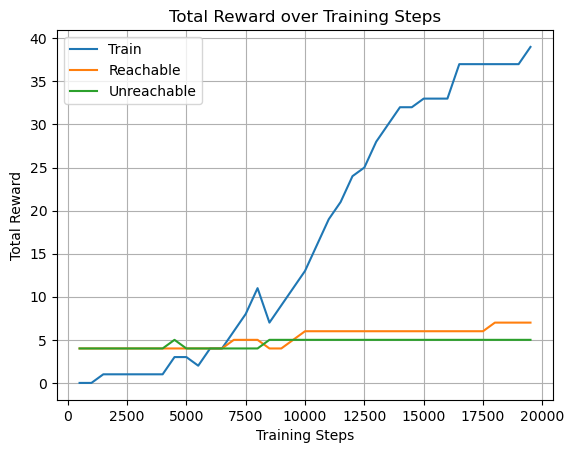

In [35]:
log_path = "d3rlpy_logs/DiscreteCQL_20240520162407"
eval_every_n = 500
max_steps = 20000
performances_train, performances_reachable, performances_unreachable = get_training_and_test_performance_over_time(log_path, eval_every_n, max_steps, train_config_path, reachable_test_config_path, unreachable_test_config_path)
plot_performances(performances_train, performances_reachable, performances_unreachable)

### Hyperparameter tuning
##### Hyperparameters to look at:
- learning_rate
- batch_size
- discount_factor
- alpha

In [16]:
def train_with_hyperparameters(learning_rate, batch_size, discount_factor, alpha, verbose=0):
    # Define the CQL algorithm with suggested hyperparameters
    cql_config = DiscreteCQLConfig(
        learning_rate=learning_rate,
        batch_size=batch_size,
        gamma=discount_factor,
        alpha=alpha
    )
    cql = cql_config.create()

    # Train the model
    cql.fit(train_dataset,
            n_steps=20000,
            n_steps_per_epoch=500)

    return cql

# Takes hyperparameters_scores dictionary as input so that if the function is interrupted the attained scores are not lost.
def hyperparameter_tuning(learning_rates, batch_sizes, discount_factors, alphas, hyperparameters_scores=None, verbose=0):
    if hyperparameters_scores is None:
        hyperparameters_scores = {}

    if hyperparameters_scores is None:
        hyperparameters_scores = {}
    if verbose: print("Starting hyperparameter tuning...")
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            for discount_factor in discount_factors:
                for alpha in alphas:
                    train_env = gym_wrapper(gym.make('MiniGrid-FourRooms-v1',
                                         agent_pos=train_config['agent positions'],
                                         goal_pos=train_config['goal positions'],
                                         doors_pos=train_config['topologies'],
                                         agent_dir=train_config['agent directions']))
                    cql = train_with_hyperparameters(learning_rate, batch_size, discount_factor, alpha)
                    total_reward, steps_done, tasks_done, num_terminated, num_truncated = evaluate_on_environment(cql, train_env, 1000000, 40, verbose)
                    hyperparameters_scores[(learning_rate, batch_size, discount_factor, alpha)] = (total_reward, steps_done, tasks_done, num_terminated, num_truncated)
                    if verbose: print(f"Progress: {len(hyperparameters_scores)}/{len(learning_rates)*len(batch_sizes)*len(discount_factors)*len(alphas)}", end="\r")
    if verbose: print("\nHyperparameter tuning done.")

    best_hyperparameters = None
    for hyperparameters in hyperparameters_scores:
        if best_hyperparameters is None or hyperparameters_scores[hyperparameters][0] > hyperparameters_scores[best_hyperparameters][0]:
            best_hyperparameters = hyperparameters
    print(f"Best hyperparameters (based on total reward): {best_hyperparameters}\n",
          f"Scores: {hyperparameters_scores[best_hyperparameters]}")

    return hyperparameters_scores

In [17]:
learning_rates = [1e-6, 1e-5, 1e-4]
batch_sizes = [64, 128, 256]
discount_factors = [0.98, 0.99, 0.999]
alphas = [0.1, 1.0, 10.0]

In [ ]:
learning_rates = [1e-4]
batch_sizes = [64, 128, 256]
discount_factors = [0.98, 0.99, 0.999]
alphas = [0.1, 1.0, 10.0]
hyperparameters_scores = {}
hyperparameters_scores = hyperparameter_tuning(learning_rates, batch_sizes, discount_factors, alphas, hyperparameters_scores, verbose=1)
print(hyperparameters_scores)

### From analysing the hyperparameters scores we can see that when the learning rate is 1e-4 the model achieves the highes possible performance the most reliably. When the learning rate is 1e-04 it achieves optimal performance (same as expert policy) on the training set regardless of the other hyperparameters.

In [55]:
hyperparameters_scores = {
    (1e-06, 64, 0.98, 0.1): (0, 4000, 40, 0, 40),
    (1e-06, 64, 0.98, 1.0): (0, 4000, 40, 0, 40), (1e-06, 64, 0.98, 10.0): (0, 4000, 40, 0, 40), (1e-06, 64, 0.99, 0.1): (0, 4000, 40, 0, 40), (1e-06, 64, 0.99, 1.0): (0, 4000, 40, 0, 40), (1e-06, 64, 0.99, 10.0): (0, 4000, 40, 0, 40), (1e-06, 64, 0.999, 0.1): (0, 4000, 40, 0, 40), (1e-06, 64, 0.999, 1.0): (0, 4000, 40, 0, 40), (1e-06, 64, 0.999, 10.0): (0, 4000, 40, 0, 40), (1e-06, 128, 0.98, 0.1): (1, 3906, 40, 1, 39), (1e-06, 128, 0.98, 1.0): (0, 4000, 40, 0, 40), (1e-06, 128, 0.98, 10.0): (0, 4000, 40, 0, 40), (1e-06, 128, 0.99, 0.1): (1, 3906, 40, 1, 39), (1e-06, 128, 0.99, 1.0): (0, 4000, 40, 0, 40), (1e-06, 128, 0.99, 10.0): (0, 4000, 40, 0, 40), (1e-06, 128, 0.999, 0.1): (1, 3906, 40, 1, 39), (1e-06, 128, 0.999, 1.0): (0, 4000, 40, 0, 40), (1e-06, 128, 0.999, 10.0): (0, 4000, 40, 0, 40), (1e-06, 256, 0.98, 0.1): (0, 4000, 40, 0, 40), (1e-06, 256, 0.98, 1.0): (0, 4000, 40, 0, 40), (1e-06, 256, 0.98, 10.0): (0, 4000, 40, 0, 40), (1e-06, 256, 0.99, 0.1): (0, 4000, 40, 0, 40), (1e-06, 256, 0.99, 1.0): (0, 4000, 40, 0, 40), (1e-06, 256, 0.99, 10.0): (0, 4000, 40, 0, 40), (1e-06, 256, 0.999, 0.1): (0, 4000, 40, 0, 40), (1e-06, 256, 0.999, 1.0): (0, 4000, 40, 0, 40), (1e-06, 256, 0.999, 10.0): (0, 4000, 40, 0, 40), (1e-05, 64, 0.98, 0.1): (35, 838, 40, 35, 5), (1e-05, 64, 0.98, 1.0): (40, 372, 40, 40, 0), (1e-05, 64, 0.98, 10.0): (40, 372, 40, 40, 0), (1e-05, 64, 0.99, 0.1): (33, 1008, 40, 33, 7), (1e-05, 64, 0.99, 1.0): (40, 372, 40, 40, 0), (1e-05, 64, 0.99, 10.0): (40, 372, 40, 40, 0), (1e-05, 64, 0.999, 0.1): (38, 556, 40, 38, 2), (1e-05, 64, 0.999, 1.0): (40, 372, 40, 40, 0), (1e-05, 64, 0.999, 10.0): (40, 372, 40, 40, 0), (1e-05, 128, 0.98, 0.1): (40, 372, 40, 40, 0), (1e-05, 128, 0.98, 1.0): (40, 372, 40, 40, 0), (1e-05, 128, 0.98, 10.0): (40, 372, 40, 40, 0), (1e-05, 128, 0.99, 0.1): (39, 460, 40, 39, 1), (1e-05, 128, 0.99, 1.0): (40, 372, 40, 40, 0), (1e-05, 128, 0.99, 10.0): (40, 372, 40, 40, 0), (1e-05, 128, 0.999, 0.1): (39, 460, 40, 39, 1), (1e-05, 128, 0.999, 1.0): (40, 372, 40, 40, 0), (1e-05, 256, 0.98, 0.1): (40, 372, 40, 40, 0), (1e-05, 256, 0.98, 1.0): (40, 372, 40, 40, 0), (1e-05, 256, 0.98, 10.0): (40, 372, 40, 40, 0), (1e-05, 256, 0.99, 0.1): (40, 372, 40, 40, 0), (1e-05, 256, 0.99, 1.0): (40, 372, 40, 40, 0), (1e-05, 256, 0.99, 10.0): (40, 372, 40, 40, 0), (1e-05, 256, 0.999, 0.1): (40, 372, 40, 40, 0), (1e-05, 256, 0.999, 1.0): (40, 372, 40, 40, 0), (1e-05, 256, 0.999, 10.0): (40, 372, 40, 40, 0), (0.0001, 64, 0.98, 0.1): (40, 372, 40, 40, 0), (0.0001, 64, 0.98, 1.0): (40, 372, 40, 40, 0), (0.0001, 64, 0.98, 10.0): (40, 372, 40, 40, 0), (0.0001, 64, 0.99, 0.1): (40, 372, 40, 40, 0), (0.0001, 64, 0.99, 1.0): (40, 372, 40, 40, 0), (0.0001, 64, 0.99, 10.0): (40, 372, 40, 40, 0), (0.0001, 64, 0.999, 0.1): (40, 372, 40, 40, 0), (0.0001, 64, 0.999, 1.0): (40, 372, 40, 40, 0), (0.0001, 64, 0.999, 10.0): (40, 372, 40, 40, 0), (0.0001, 128, 0.98, 0.1): (40, 372, 40, 40, 0), (0.0001, 128, 0.98, 1.0): (40, 372, 40, 40, 0), (0.0001, 128, 0.98, 10.0): (40, 372, 40, 40, 0), (0.0001, 128, 0.99, 0.1): (40, 372, 40, 40, 0), (0.0001, 128, 0.99, 1.0): (40, 372, 40, 40, 0), (0.0001, 128, 0.99, 10.0): (40, 372, 40, 40, 0), (0.0001, 128, 0.999, 0.1): (40, 372, 40, 40, 0), (0.0001, 128, 0.999, 1.0): (40, 372, 40, 40, 0), (0.0001, 128, 0.999, 10.0): (40, 372, 40, 40, 0), (0.0001, 256, 0.98, 0.1): (40, 372, 40, 40, 0), (0.0001, 256, 0.98, 1.0): (40, 372, 40, 40, 0), (0.0001, 256, 0.98, 10.0): (40, 372, 40, 40, 0), (0.0001, 256, 0.99, 0.1): (40, 372, 40, 40, 0), (0.0001, 256, 0.99, 1.0): (40, 372, 40, 40, 0), (0.0001, 256, 0.99, 10.0): (40, 372, 40, 40, 0), (0.0001, 256, 0.999, 0.1): (40, 372, 40, 40, 0), (0.0001, 256, 0.999, 1.0): (40, 372, 40, 40, 0), (0.0001, 256, 0.999, 10.0): (40, 372, 40, 40, 0)}
optimal_params = []

learning_rate_e6 = 0
learning_rate_e5 = 0
learning_rate_e4 = 0

batch_size_64 = 0
batch_size_128 = 0
batch_size_256 = 0

discount_factor_98 = 0
discount_factor_99 = 0
discount_factor_999 = 0

alpha_01 = 0
alpha_1 = 0
alpha_10 = 0

for a,b,c,d in hyperparameters_scores:
    e,f,g,h,i = hyperparameters_scores[(a,b,c,d)]
    least_steps = 372
    # if not a == 1e-04:
    #     continue
    if e == 40 and f == 372:
        if a == 1e-04: learning_rate_e4 += 1
        if a == 1e-05: learning_rate_e5 += 1
        if a == 1e-06: learning_rate_e6 += 1

        if b == 64: batch_size_64 += 1
        if b == 128: batch_size_128 += 1
        if b == 256: batch_size_256 += 1

        if c == 0.98: discount_factor_98 += 1
        if c == 0.99: discount_factor_99 += 1
        if c == 0.999: discount_factor_999 += 1

        if d == 0.1: alpha_01 += 1
        if d == 1.0: alpha_1 += 1
        if d == 10.0: alpha_10 += 1

        optimal_params.append((a,b,c,d))
print("learning_rate_e6: ", learning_rate_e6)
print("learning_rate_e5: ", learning_rate_e5)
print("learning_rate_e4: ", learning_rate_e4)

print("batch_size_64: ", batch_size_64)
print("batch_size_128: ", batch_size_128)
print("batch_size_256: ", batch_size_256)

print("discount_factor_98: ", discount_factor_98)
print("discount_factor_99: ", discount_factor_99)
print("discount_factor_999: ", discount_factor_999)

print("alpha_01: ", alpha_01)
print("alpha_1: ", alpha_1)
print("alpha_10: ", alpha_10)

learning_rate_e6:  0
learning_rate_e5:  0
learning_rate_e4:  27
batch_size_64:  9
batch_size_128:  9
batch_size_256:  9
discount_factor_98:  9
discount_factor_99:  9
discount_factor_999:  9
alpha_01:  9
alpha_1:  9
alpha_10:  9


In [40]:
for a,b,c,d in hyperparameters_scores:
    e,f,g,h,i = hyperparameters_scores[(a,b,c,d)]
    # total_reward, steps_done, tasks_done, num_terminated, num_truncated
    # print(a, b, c, d, "\t", e, f, h, i)
print(hyperparameters_scores)

{(0.0001, 64, 0.98, 0.1): (40, 372, 40, 40, 0), (0.0001, 64, 0.98, 1.0): (40, 372, 40, 40, 0), (0.0001, 64, 0.98, 10.0): (40, 372, 40, 40, 0), (0.0001, 64, 0.99, 0.1): (40, 372, 40, 40, 0), (0.0001, 64, 0.99, 1.0): (40, 372, 40, 40, 0), (0.0001, 64, 0.99, 10.0): (40, 372, 40, 40, 0), (0.0001, 64, 0.999, 0.1): (40, 372, 40, 40, 0), (0.0001, 64, 0.999, 1.0): (40, 372, 40, 40, 0), (0.0001, 64, 0.999, 10.0): (40, 372, 40, 40, 0), (0.0001, 128, 0.98, 0.1): (40, 372, 40, 40, 0), (0.0001, 128, 0.98, 1.0): (40, 372, 40, 40, 0), (0.0001, 128, 0.98, 10.0): (40, 372, 40, 40, 0), (0.0001, 128, 0.99, 0.1): (40, 372, 40, 40, 0), (0.0001, 128, 0.99, 1.0): (40, 372, 40, 40, 0), (0.0001, 128, 0.99, 10.0): (40, 372, 40, 40, 0), (0.0001, 128, 0.999, 0.1): (40, 372, 40, 40, 0), (0.0001, 128, 0.999, 1.0): (40, 372, 40, 40, 0), (0.0001, 128, 0.999, 10.0): (40, 372, 40, 40, 0), (0.0001, 256, 0.98, 0.1): (40, 372, 40, 40, 0), (0.0001, 256, 0.98, 1.0): (40, 372, 40, 40, 0), (0.0001, 256, 0.98, 10.0): (40, 372,

In [15]:
train_dataset = get_expert_dataset_from_config(train_config)
train_dataset = d3rlpy.dataset.MDPDataset(
    observations=train_dataset.get("observations"),
    actions=train_dataset.get("actions"),
    rewards=train_dataset.get("rewards"),
    terminals=train_dataset.get("terminals"),
)
train_dataset.dataset_info

2024-05-17 17:10.37 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('uint8')], shape=[(324,)]) reward_signature=Signature(dtype=[dtype('int32')], shape=[(1,)])
2024-05-17 17:10.37 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-05-17 17:10.37 [info     ] Action size has been automatically determined. action_size=3


DatasetInfo(observation_signature=Signature(dtype=[dtype('uint8')], shape=[(324,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=3)